In [56]:
import pickle
import pandas as pd
import pandas_profiling
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("pastel")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostRegressor 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, r2_score, mean_squared_error, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

from rfpimp import importances

import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 500

In [3]:
# read in data
sentiment_df = pd.read_pickle('data/twitter/cities_sentiment_data.pkl')
census_df = pd.read_pickle('data/census/census_data.pkl')

In [4]:
# subset sentiment data
sentiment_df2 = sentiment_df[["closest_city",
         "closest_state",
#          "negative",
#          "neutral",
#          "positive",
#          "Population2010",
#          "ACCESS2_AdjPrev",
#          "ARTHRITIS_AdjPrev",
#          "BINGE_AdjPrev",
#          "BPHIGH_AdjPrev",
#          "BPMED_AdjPrev",
#          "CANCER_AdjPrev",
#          "CASTHMA_AdjPrev",
#          "CHD_AdjPrev",
#          "CHECKUP_AdjPrev",
#          "CHOLSCREEN_AdjPrev",
#          "COLON_SCREEN_AdjPrev",
#          "COPD_AdjPrev",
#          "COREM_AdjPrev",
#          "COREW_AdjPrev",
#          "CSMOKING_AdjPrev",
#          "DENTAL_AdjPrev",
#          "DIABETES_AdjPrev",
#          "HIGHCHOL_AdjPrev",
#          "KIDNEY_AdjPrev",
#          "LPA_AdjPrev",
#          "MAMMOUSE_AdjPrev",
#          "MHLTH_AdjPrev",
         "OBESITY_cut",
#          "PAPTEST_AdjPrev",
#          "PHLTH_AdjPrev",
#          "SLEEP_AdjPrev",
#          "STROKE_AdjPrev",
#          "TEETHLOST_AdjPrev"
         ]]

In [5]:
# merge sentiment to cdc
df = pd.merge(sentiment_df2, 
                       census_df, 
                       left_on=('closest_city','closest_state'), 
                       right_on=('closest_city','closest_state'), 
                       indicator = True)  

In [6]:
df

,closest_city,closest_state,OBESITY_cut,"Population estimates, July 1, 2018, (V2018)","Population estimates base, April 1, 2010, (V2018)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2018, (V2018)","Population, Census, April 1, 2010","Persons under 5 years, percent","Persons under 18 years, percent","Persons 65 years and over, percent","Female persons, percent","White alone, percent","Black or African American alone, percent","American Indian and Alaska Native alone, percent","Asian alone, percent","Native Hawaiian and Other Pacific Islander alone, percent","Two or More Races, percent","Hispanic or Latino, percent","White alone, not Hispanic or Latino, percent","Veterans, 2013-2017","Foreign born persons, percent, 2013-2017","Owner-occupied housing unit rate, 2013-2017","Median value of owner-occupied housing units, 2013-2017","Median selected monthly owner costs -with a mortgage, 2013-2017","Median selected monthly owner costs -without a mortgage, 2013-2017","Median gross rent, 2013-2017","Households, 2013-2017","Persons per household, 2013-2017","Living in same house 1 year ago, percent of persons age 1 year+, 2013-2017","Language other than English spoken at home, percent of persons age 5 years+, 2013-2017","Households with a computer, percent, 2013-2017","Households with a broadband Internet subscription, percent, 2013-2017","High school graduate or higher, percent of persons age 25 years+, 2013-2017","Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017","With a disability, under age 65 years, percent, 2013-2017","Persons without health insurance, under age 65 years, percent","In civilian labor force, total, percent of population age 16 years+, 2013-2017","In civilian labor force, female, percent of population age 16 years+, 2013-2017","Total accommodation and food services sales, 2012 (1,000)","Total health care and social assistance receipts/revenue, 2012 (1,000)","Total manufacturers shipments, 2012 (1,000)","Total merchant wholesaler sales, 2012 (1,000)","Total retail sales, 2012 (1,000)","Total retail sales per capita, 2012","Mean travel time to work (minutes), workers age 16 years+, 2013-2017","Median household income (in 2017 dollars), 2013-2017","Per capita income in past 12 months (in 2017 dollars), 2013-2017","Persons in poverty, percent","All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",_merge
0,Abilene,TX,high,122999.0,117512.0,4.700000,117063.0,7.3,23.100000,12.600000,48.299999,73.099998,10.100000,1.1,2.100000,0.0,3.3,26.799999,58.799999,9310.0,6.100000,54.500000,106800.0,1166.0,426.0,846.0,42287.0,2.58,73.300003,19.000000,86.800003,71.699997,85.000000,22.100000,11.500000,17.500000,57.500000,58.700001,0.0,0.0,898344.0,1861865.0,2087352.0,17557.0,15.7,46093.0,22819.0,17.700001,9823.0,5551.0,2991.0,2212.0,7035.0,1262.0,7685.0,1096.199951,106.790001,both
1,Akron,OH,high,198006.0,199135.0,-0.600000,199110.0,6.4,21.200001,14.200000,51.900002,60.299999,30.500000,0.3,4.000000,0.0,4.3,2.400000,58.799999,12125.0,5.900000,51.000000,80100.0,981.0,403.0,713.0,84443.0,2.29,85.800003,7.200000,81.199997,70.500000,86.500000,20.799999,11.800000,11.800000,62.299999,59.299999,257415.0,2883921.0,3477813.0,1695828.0,1906638.0,9603.0,21.5,36223.0,22416.0,24.100000,16308.0,8724.0,6308.0,4488.0,11112.0,1546.0,13855.0,3209.699951,62.029999,both
2,Albuquerque,NM,medium,560218.0,546191.0,2.600000,545852.0,6.3,23.000000,14.200000,51.200001,73.599998,3.300000,4.4,2.700000,0.1,4.3,48.500000,40.000000,38908.0,9.900000,59.799999,188500.0,1324.0,416.0,833.0,221119.0,2.49,83.599998,28.700001,87.199997,76.300003,89.500000,34.299999,9.500000,12.100000,63.799999,59.500000,1578983.0,5183979.0,0.0,4784857.0,9067367.0,16325.0,21.2,49878.0,28229.0,18.200001,42272.0,20208.0,16129.0,16511.0,23116.0,414

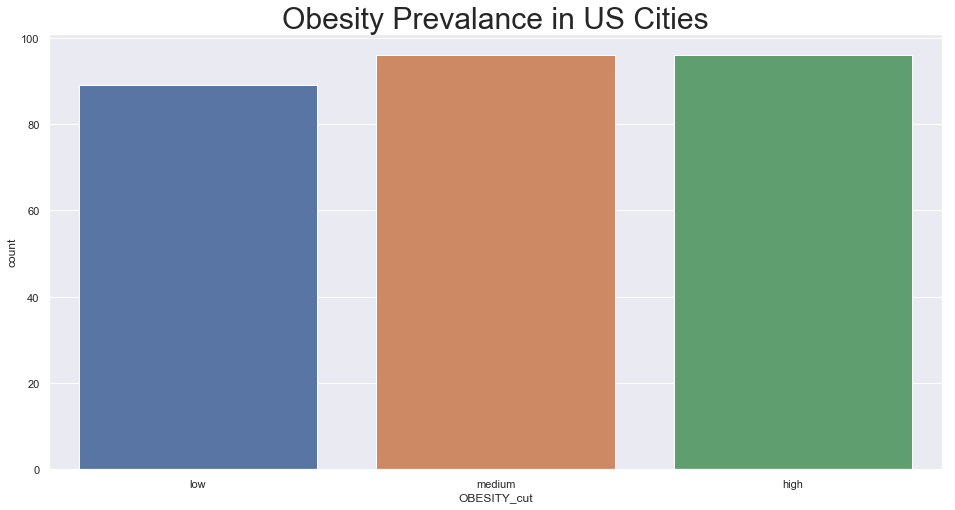

In [7]:
#See result of binning
sns.set_context(font_scale=20) 
sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize = (16,8))
ax = sns.countplot(df["OBESITY_cut"]);
ax.axes.set_title("Obesity Prevalance in US Cities",fontsize=30);
# fig.savefig('.png') #not useful for presentation

In [8]:
len(df)

281

# Modeling

### first without sentiment

In [39]:
# Feature Engineering
X = df.drop(['closest_city','closest_state', '_merge',
            'OBESITY_cut',
             "All firms, 2012", 
             "Households with a broadband Internet subscription, percent, 2013-2017",
             "Households, 2013-2017",
             "Language other than English spoken at home, percent of persons age 5 years+, 2013-2017",
             "Median selected monthly owner costs -with a mortgage, 2013-2017",
             "Women-owned firms, 2012",
             "Nonminority-owned firms, 2012",
             "Nonveteran-owned firms, 2012",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Population, Census, April 1, 2010",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Total health care and social assistance receipts/revenue, 2012 (1,000)",
             "Total manufacturers shipments, 2012 (1,000)",
             "Total merchant wholesaler sales, 2012 (1,000)",
             "Total retail sales, 2012 (1,000)",
             "Veteran-owned firms, 2012",
             "Total accommodation and food services sales, 2012 (1,000)",
             "Native Hawaiian and Other Pacific Islander alone, percent",
             "Men-owned firms, 2012",
             "Population estimates, July 1, 2018,  (V2018)"   
             ], axis = 1)
y = df["OBESITY_cut"]

In [40]:
X["Persons per household, 2013-2017"] = X["Persons per household, 2013-2017"].astype('float32')
X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"] = X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"].astype('float32')
X = pd.DataFrame(X).fillna(0)


In [41]:
#futher reduce features
X = X[[
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2018,  (V2018)",
    "Persons 65 years and over, percent",
    "White alone, percent",
    "Black or African American alone, percent",
    "Asian alone, percent",
    "Hispanic or Latino, percent",
    "Veterans, 2013-2017",
    "Median gross rent, 2013-2017",
    "Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017",
    "Persons  without health insurance, under age 65 years, percent",
    "In civilian labor force, total, percent of population age 16 years+, 2013-2017",
    "Mean travel time to work (minutes), workers age 16 years+, 2013-2017",
    "Per capita income in past 12 months (in 2017 dollars), 2013-2017",
    "Persons in poverty, percent"
    ]]


scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                        random_state=4)

In [43]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196, 14), (85, 14), (196,), (85,))

## Logistic Regression

In [14]:
logistic = LogisticRegression(penalty='l2',
                            dual=False,
                            tol=0.0001,
                            C=1.0,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight=None,
                            random_state=None,
                            solver='warn',
                            max_iter=100,
                            multi_class='warn',
                            verbose=0,
                            warm_start=False, n_jobs=None, l1_ratio=None)
logistic.fit(X_train, y_train)
logistic_pred = logistic.predict(X_test)

print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

        high       0.80      0.75      0.77        32
         low       0.84      0.81      0.82        26
      medium       0.57      0.63      0.60        27

    accuracy                           0.73        85
   macro avg       0.74      0.73      0.73        85
weighted avg       0.74      0.73      0.73        85



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Random Forest

In [57]:
# Add column of random numbers
# X_train['random'] = np.random.random(size=len(X_train))
# X_test['random'] = np.random.random(size=len(X_test))
# X['random'] = np.random.random(size=len(X))

rf = RandomForestClassifier(n_estimators='warn',
                            criterion='gini',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)
rf.fit(X_train, y_train)
# importances = rf.feature_importances_
RF_pred = rf.predict(X_test)
print(classification_report(y_test, RF_pred))


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

        high       0.79      0.72      0.75        32
         low       0.77      0.88      0.82        26
      medium       0.58      0.56      0.57        27

    accuracy                           0.72        85
   macro avg       0.71      0.72      0.71        85
weighted avg       0.72      0.72      0.71        85



In [53]:
# importances = rf.feature_importances_
# feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
#                            index=X.columns)
# feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
# feat_scores_topten = feat_scores.tail(10)
# feat_scores_topten.plot(kind='barh')
# plt.title("Feature Importance")
# plt.savefig('images/Feature_Importance')

In [54]:
imp = importances(rf, X_test, y_test) # permutation

TypeError: 'numpy.ndarray' object is not callable

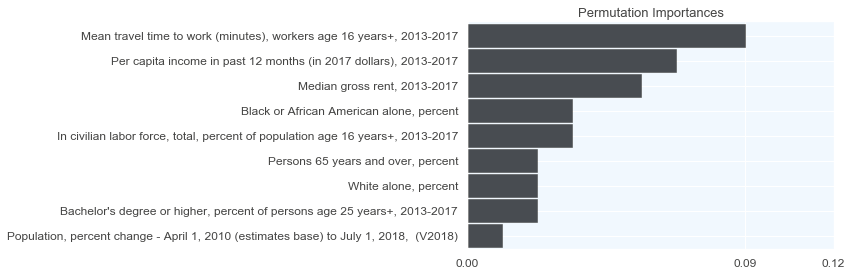

In [61]:
viz = plot_importances(imp[0:9],  yrot=0,
                                label_fontsize=12,
                                width=12,
                                minheight=1.5,
                                vscale=2.0,
                                imp_range=(0, imp['Importance'].max() + .03),
                                color='#484c51',
                                bgcolor='#F1F8FE',  # seaborn uses '#F1F8FE'
                                xtick_precision=2,
                                title='Permutation Importances')

viz.view()


## Gradient Boosting

In [19]:
gb = GradientBoostingClassifier(loss='deviance', 
                           learning_rate=0.001, 
                           n_estimators=100, 
                           subsample=1.0, 
                           criterion='friedman_mse', 
                           min_samples_split=4, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_depth=1, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           init=None, 
                           random_state=None, 
                           max_features=None, 
                           verbose=0, 
                           max_leaf_nodes=None, 
                           warm_start=False, 
                           presort='auto', 
                           validation_fraction=0.1, 
                           n_iter_no_change=None, 
                           tol=0.0001)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

        high       0.70      0.59      0.64        32
         low       0.76      0.50      0.60        26
      medium       0.39      0.59      0.47        27

    accuracy                           0.56        85
   macro avg       0.62      0.56      0.57        85
weighted avg       0.62      0.56      0.58        85



### can't do a chi-sq because sentiment isn't categorical

# Do models with sentiment



In [67]:
# subset sentiment data
sentiment_df2 = sentiment_df[["closest_city",
         "closest_state",
          "negative",
#           "neutral",
          "positive",
#          "Population2010",
#          "ACCESS2_AdjPrev",
#          "ARTHRITIS_AdjPrev",
#          "BINGE_AdjPrev",
#          "BPHIGH_AdjPrev",
#          "BPMED_AdjPrev",
#          "CANCER_AdjPrev",
#          "CASTHMA_AdjPrev",
#          "CHD_AdjPrev",
#          "CHECKUP_AdjPrev",
#          "CHOLSCREEN_AdjPrev",
#          "COLON_SCREEN_AdjPrev",
#          "COPD_AdjPrev",
#          "COREM_AdjPrev",
#          "COREW_AdjPrev",
#          "CSMOKING_AdjPrev",
#          "DENTAL_AdjPrev",
#          "DIABETES_AdjPrev",
#          "HIGHCHOL_AdjPrev",
#          "KIDNEY_AdjPrev",
#          "LPA_AdjPrev",
#          "MAMMOUSE_AdjPrev",
#          "MHLTH_AdjPrev",
         "OBESITY_cut",
#          "PAPTEST_AdjPrev",
#          "PHLTH_AdjPrev",
#          "SLEEP_AdjPrev",
#          "STROKE_AdjPrev",
#          "TEETHLOST_AdjPrev"
         ]]

# merge sentiment to cdc
df = pd.merge(sentiment_df2, 
                       census_df, 
                       left_on=('closest_city','closest_state'), 
                       right_on=('closest_city','closest_state'), 
                       indicator = True) 

# Feature Engineering
X = df.drop(['closest_city','closest_state', '_merge',
            'OBESITY_cut',
             "All firms, 2012", 
             "Households with a broadband Internet subscription, percent, 2013-2017",
             "Households, 2013-2017",
             "Language other than English spoken at home, percent of persons age 5 years+, 2013-2017",
             "Median selected monthly owner costs -with a mortgage, 2013-2017",
             "Women-owned firms, 2012",
             "Nonminority-owned firms, 2012",
             "Nonveteran-owned firms, 2012",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Population, Census, April 1, 2010",
             "Population estimates base, April 1, 2010,  (V2018)",
             "Total health care and social assistance receipts/revenue, 2012 (1,000)",
             "Total manufacturers shipments, 2012 (1,000)",
             "Total merchant wholesaler sales, 2012 (1,000)",
             "Total retail sales, 2012 (1,000)",
             "Veteran-owned firms, 2012",
             "Total accommodation and food services sales, 2012 (1,000)",
             "Native Hawaiian and Other Pacific Islander alone, percent",
             "Men-owned firms, 2012",
             "Population estimates, July 1, 2018,  (V2018)"   
             ], axis = 1)
y = df["OBESITY_cut"]

X["Persons per household, 2013-2017"] = X["Persons per household, 2013-2017"].astype('float32')
X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"] = X["Mean travel time to work (minutes), workers age 16 years+, 2013-2017"].astype('float32')
X = pd.DataFrame(X).fillna(0)

#futher reduce features
X = X[[
    "negative",
    "positive",
    "Population, percent change - April 1, 2010 (estimates base) to July 1, 2018,  (V2018)",
    "Persons 65 years and over, percent",
    "White alone, percent",
    "Black or African American alone, percent",
    "Asian alone, percent",
    "Hispanic or Latino, percent",
    "Veterans, 2013-2017",
    "Median gross rent, 2013-2017",
    "Bachelor's degree or higher, percent of persons age 25 years+, 2013-2017",
    "Persons  without health insurance, under age 65 years, percent",
    "In civilian labor force, total, percent of population age 16 years+, 2013-2017",
    "Mean travel time to work (minutes), workers age 16 years+, 2013-2017",
    "Per capita income in past 12 months (in 2017 dollars), 2013-2017",
    "Persons in poverty, percent"
    ]]


scaler = StandardScaler()
scaler.fit(X)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                        random_state=4)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((196, 16), (85, 16), (196,), (85,))

In [22]:
logistic = LogisticRegression(penalty='l2',
                            dual=False,
                            tol=0.0001,
                            C=1.0,
                            fit_intercept=True,
                            intercept_scaling=1,
                            class_weight=None,
                            random_state=None,
                            solver='warn',
                            max_iter=100,
                            multi_class='warn',
                            verbose=0,
                            warm_start=False, n_jobs=None, l1_ratio=None)
logistic.fit(X_train, y_train)
logistic_pred = logistic.predict(X_test)

print(classification_report(y_test, logistic_pred))

              precision    recall  f1-score   support

        high       0.83      0.75      0.79        32
         low       0.84      0.81      0.82        26
      medium       0.58      0.67      0.62        27

    accuracy                           0.74        85
   macro avg       0.75      0.74      0.74        85
weighted avg       0.75      0.74      0.75        85



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [23]:
#to find p-values associated with high obesity
y_stats = y.replace({'low': 0, 'medium': 0, 'high':1})
X_stats = X[["positive","negative"]]

In [24]:
import statsmodels.api as sm

logit_model=sm.Logit(y_stats.astype(float), X_stats.astype(float))

In [25]:
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.654651
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            OBESITY_cut   No. Observations:                  281
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                            1
Date:                Tue, 23 Jul 2019   Pseudo R-squ.:                -0.01952
Time:                        15:54:20   Log-Likelihood:                -183.96
converged:                       True   LL-Null:                       -180.43
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
positive      -1.3982      0.348     -4.021      0.000      -2.080      -0.717
negative      -0.1946      0.

In [68]:
# X_train['random'] = np.random.random(size=len(X_train))
# X_test['random'] = np.random.random(size=len(X_test))
# X['random'] = np.random.random(size=len(X))
# {'bootstrap': True,
#  'max_depth': 90,
#  'max_features': 3,
#  'min_samples_leaf': 4,
#  'min_samples_split': 8,
#  'n_estimators': 100}

rf = RandomForestClassifier(n_estimators=100,
                            criterion='gini',
                            max_depth=90,
                            min_samples_split=8,
                            min_samples_leaf=4,
                            min_weight_fraction_leaf=0.0,
                            max_features=3,
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None)
rf.fit(X_train, y_train)

RF_pred = rf.predict(X_test)
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

        high       0.84      0.66      0.74        32
         low       0.81      0.81      0.81        26
      medium       0.53      0.67      0.59        27

    accuracy                           0.71        85
   macro avg       0.73      0.71      0.71        85
weighted avg       0.73      0.71      0.71        85



In [64]:
# importances = rf.feature_importances_
# feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
#                            index=X.columns)
# feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
# feat_scores_topten = feat_scores.tail(10)
# feat_scores_topten.plot(kind='barh')
# plt.title("Feature Importance")
# plt.savefig('images/Feature_Importance')

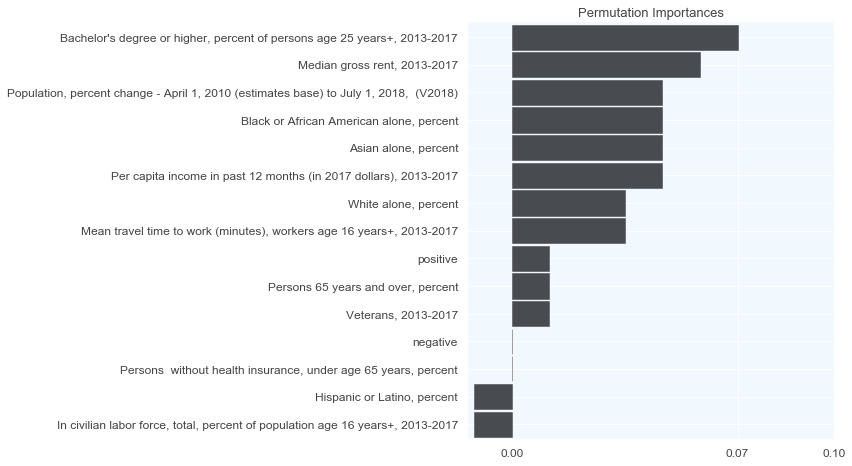

In [75]:

imp = importances(rf, X_test, y_test) # permutation
viz = plot_importances(imp[0:15],  yrot=0,
                                label_fontsize=12,
                                width=12,
                                minheight=1.5,
                                vscale=2.0,
                                imp_range=(0, imp['Importance'].max() + .03),
                                color='#484c51',
                                bgcolor='#F1F8FE',  # seaborn uses '#F1F8FE'
                                xtick_precision=2,
                                title='Permutation Importances')

viz.view()


In [74]:
gb = GradientBoostingClassifier(loss='deviance', 
                           learning_rate=0.001, 
                           n_estimators=100, 
                           subsample=1.0, 
                           criterion='friedman_mse', 
                           min_samples_split=4, 
                           min_samples_leaf=1, 
                           min_weight_fraction_leaf=0.0, 
                           max_depth=1, 
                           min_impurity_decrease=0.0, 
                           min_impurity_split=None, 
                           init=None, 
                           random_state=None, 
                           max_features=None, 
                           verbose=0, 
                           max_leaf_nodes=None, 
                           warm_start=False, 
                           presort='auto', 
                           validation_fraction=0.1, 
                           n_iter_no_change=None, 
                           tol=0.0001)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
print(classification_report(y_test, gb_pred))

              precision    recall  f1-score   support

        high       0.70      0.59      0.64        32
         low       0.76      0.50      0.60        26
      medium       0.39      0.59      0.47        27

    accuracy                           0.56        85
   macro avg       0.62      0.56      0.57        85
weighted avg       0.62      0.56      0.58        85



# plot partial dependence

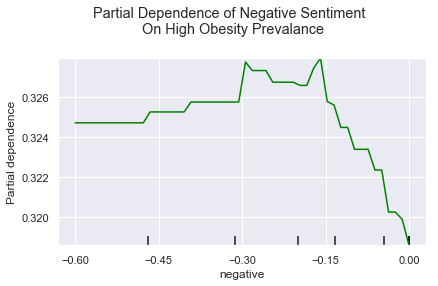

In [79]:
## create partial dependence plot on RF model
from sklearn.inspection import plot_partial_dependence

features = [0]
plot_partial_dependence(rf, X, features, feature_names=X.columns,
                            n_jobs=3, grid_resolution=50, target="high")
fig = plt.gcf()
fig.suptitle('Partial Dependence of Negative Sentiment \n On High Obesity Prevalance\n'
                 )
plt.subplots_adjust(top=0.8)  # tight_layout causes overlap with suptitle
plt.savefig('images/pdp_negative.png')

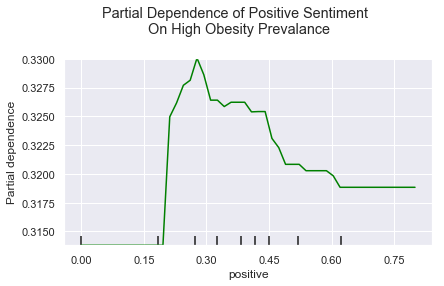

In [82]:
features = [1]
plot_partial_dependence(rf, X, features, feature_names=X.columns,
                            n_jobs=3, grid_resolution=50, target="high")
fig = plt.gcf()
fig.suptitle('Partial Dependence of Positive Sentiment \n On High Obesity Prevalance\n'
                 )
plt.subplots_adjust(top=0.8) 
fig.savefig('images/pdp_positive.png') 

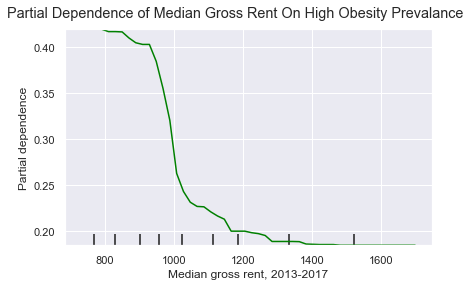

In [88]:
features = [9]
plot_partial_dependence(rf, X, features, feature_names=X.columns,
                            n_jobs=3, grid_resolution=50, target="high")
fig = plt.gcf()
fig.suptitle('Partial Dependence of Median Gross Rent On High Obesity Prevalance \n'
                 )
plt.subplots_adjust(top=0.9) 
fig.savefig('images/pdp_rent.png')

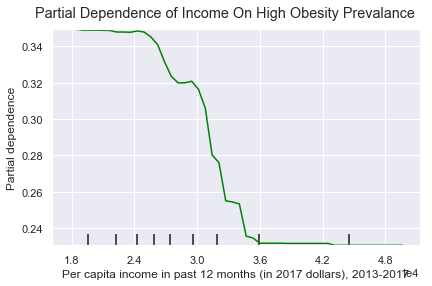

In [89]:
features = [14]
plot_partial_dependence(rf, X, features, feature_names=X.columns,
                            n_jobs=3, grid_resolution=50, target="high")
fig = plt.gcf()
fig.suptitle('Partial Dependence of Income On High Obesity Prevalance\n'
                 )
plt.subplots_adjust(top=0.9) 
fig.savefig('images/pdp_income.png')

In [208]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn import svm


    
# # Learn to predict each class against the other
# classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
# y_score = classifier.fit(X_train, y_train).decision_function(X_test)
# from sklearn.preprocessing import label_binarize
# from sklearn.metrics import roc_curve, auc

# # Binarize the output
# y = label_binarize(y, classes=[0, 1, 2])
# n_classes = y.shape[1]
# n_classes
# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

## Confusion Matrix for RF

In [33]:
y_pred = rf.predict(X_test)

    
    
# Visualise classical Confusion Matrix

CM = confusion_matrix(y_test, y_pred)
print(CM)

[[22  0 10]
 [ 0 21  5]
 [ 6  5 16]]


In [34]:
accuracy = np.trace(CM) / float(np.sum(CM))
misclass = 1 - accuracy
accuracy, misclass

(0.6941176470588235, 0.3058823529411765)

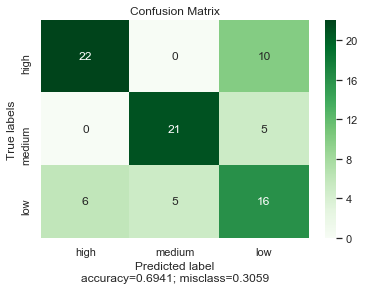

In [38]:
# Visualize it as a heatmap
ax= plt.subplot()
sns.heatmap(CM, annot=True, ax = ax, fmt='g', cmap='Greens')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['high', 'medium','low']); 
ax.yaxis.set_ticklabels(['high', 'medium', 'low']);

plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
plt.savefig('images/confusion_matrix.png')

# Grid Search to find optimal RF parameters

In [205]:
rf = RandomForestClassifier()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

rf_pred = grid_search.predict(X_test)

grid_search.score(X_test,y_test)


print(classification_report(y_test, rf_pred))

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.0min


              precision    recall  f1-score   support

        high       0.85      0.72      0.78        32
         low       0.84      0.81      0.82        26
      medium       0.58      0.70      0.63        27

    accuracy                           0.74        85
   macro avg       0.76      0.74      0.75        85
weighted avg       0.76      0.74      0.75        85



[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.6min finished


In [206]:
grid_search.best_params_ 

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 100}